In [24]:

import os
import pandas as pd
import numpy as np
# Need s3fs as well
import dotenv
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.statespace.sarimax import SARIMAXResults
from sklearn.metrics import mean_squared_error
from math import sqrt
import warnings
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

In [25]:
price_coins = ['avalanche-2', ## check?
'binancecoin', ##
'bitcoin', ##
'cardano', ## 
'dogecoin', ##
'ethereum', ## 
'polkadot', ## 
'ripple', ## check, XRP?
'solana', ## 
'terra-luna'] ## check

In [26]:
sentiment_coins = ['Avalanchefinal',
'BNBfinal',
'Bitcoinfinal',
'Cardanofinal',
'Dogefinal',
'Ethereumfinal',
'PolkaDotfinal',
'XRPfinal',
'Solanafinal',
'Terrafinal'] 

In [27]:
dotenv.load_dotenv('.env', override=True)

True

In [28]:

AWS_S3_BUCKET = os.getenv("AWS_S3_BUCKET_PRICE")
AWS_ACCESS_KEY_ID = os.getenv("AWS_ACCESS_KEY_ID")
AWS_SECRET_ACCESS_KEY = os.getenv("AWS_SECRET_ACCESS_KEY")

price_data = []

for coin in price_coins:

    price_df = pd.read_csv(
        f"s3://{AWS_S3_BUCKET}/{coin}.csv",
        storage_options={
            "key": AWS_ACCESS_KEY_ID,
            "secret": AWS_SECRET_ACCESS_KEY
        },
    )

    price_df.index = pd.to_datetime(price_df['Day'], format='%Y-%m-%d')
    price_df.drop(columns=['Day'], inplace=True)
    price_df.drop(price_df.tail(1).index,inplace=True) 

    price_data.append(price_df)

In [29]:

AWS_S3_BUCKET = os.getenv("AWS_S3_BUCKET_SENTIMENT")
AWS_ACCESS_KEY_ID = os.getenv("AWS_ACCESS_KEY_ID")
AWS_SECRET_ACCESS_KEY = os.getenv("AWS_SECRET_ACCESS_KEY")

sentiment_data = []

for coin in sentiment_coins:
    if coin == '':
        sentiment_data.append(None)
        continue

    sentiment_df = pd.read_csv(
        f"s3://{AWS_S3_BUCKET}/{coin}.csv",
        storage_options={
            "key": AWS_ACCESS_KEY_ID,
            "secret": AWS_SECRET_ACCESS_KEY
        },
    )

    sentiment_df.index = pd.to_datetime(sentiment_df['date'], format='%Y-%m-%d')
    sentiment_df.drop(columns=['date'], inplace=True)
    # print(f'Coin: {coin}, last date:{sentiment_df.last_valid_index()}')
    sentiment_data.append(sentiment_df)



FileNotFoundError: cse6242-sentiment-analysis-output/Dogecoinfinal.csv

In [ ]:
price_data[0]

,Price,Market Cap,Volume
Day,,,
2021-09-01,39.62,6.930748e+09,8.036312e+08
2021-09-02,42.44,7.488956e+09,9.921274e+08
2021-09-03,47.53,8.208052e+09,8.837715e+08
2021-09-04,45.81,8.054269e+09,1.237827e+09
2021-09-05,47.25,8.366989e+09,8.654498e+08
...,...,...,...
2022-02-24,73.91,1.819334e+10,1.294351e+09
2022-02-25,76.61,1.883056e+10,2.333968e+09
2022-02-26,80.98,1.992930e+10,1.478105e+09


In [ ]:
sentiment_data[0]

,sentiment,sample_tweet1,sample_tweet2,sample_tweet3,sample_tweet4,sample_tweet5,coin
date,,,,,,,
2021-09-01,0.088055,Found of one of the hidden gem#Avalanche #AV...,@jjjmwinriego26_ @chitaglorya @Avalanche_Spac...,@AvaXlauncher Don't you dare sleeping on Aval...,@MartiniGuyYT @solana and @avalancheavax beca...,@monimine_ @chitaglorya @Avalanche_Space @Pol...,Avalanche
2021-09-02,-0.175432,\ud83d\udd37@AvalaunchApp is a startup platfo...,#NowPlaying Arsenales - Avalanche on @BN4IA #...,"Sam Bankman-Fried, CEO at FTX, Claims Blockch...",Love Avalanche projects! Lets get that giveaw...,The price of #Avalanche is currently $43.13 #...,Avalanche
2021-09-03,-0.091044,@_MiroToZero_ You are drunk the avalanche hav...,\ud83d\udcb8TOP 8 SALES OF THE DAY\ud83d\udcb...,@Avalanche_Punks @jtrollip @jtrollip is the m...,If anyone wants to celebrate the Game 7 win a...,@aolsen1017 we did the logan pass hidden lake...,Avalanche
2021-09-04,-0.229587,Sushmita Sen Pens A Sweet Birthday Wish For \...,Sushmita Sen Pens A Sweet Birthday Wish For '...,@Cryptoyieldinfo @defipeasant People should t...,@el33th4xor @kevinsekniqi I invested in AVAX ...,@YourFriend_Nico @5P4C3K1773N @HardDriveMag T...,Avalanche
2021-09-05,-0.277395,James Arthur - Avalanche (Live Session) https...,{I'm really excited for this event - and I'm ...,Leveraged yield farmers can borrow funds to i...,Over 1.3m$ traded in the last 24 hrs! Interes...,"I have now used eth, polygon, Cardano, BSC, F...",Avalanche
...,...,...,...,...,...,...,...
2022-02-24,-0.090851,My main list of tokens that I am/ will be acc...,"We ridin with biden, get in $JOE now! @trader...",$SOL $LUNA $AVAX looking like diamonds in a s...,$Bend $Nomics $Avax#AVAX #Avalanche #cryptocu...,I love a good clearance sale! What are we buy...,Avalanche
2022-02-25,0.003866,@FLS_News_1 @traderjoe_xyz @FiefGuild all we ...,And we up 20% on L1s!Yeeeeet!$ftm $avax $eth ...,\ud83d\udd39 TOP TRENDING SEARCHES #CoinGecko...,Let's have a look at some hottest events duri...,(9) Cryptocurrencies$BTC $ETH $USDT $BNB $USD...,Avalanche
2022-02-26,-0.067622,Active trading pairs On Binance Right Now !!!...,Maximizer - $MAXI ( @maximizer_xyz ) update! ...,TOP 10 #dApps based on cumulative total reven...,#Crypto #Cryptocurrency Closed positions and ...,Avalanche 1-month social activity:Galaxy Scor...,Avalanche


In [ ]:
predict_days = 32


In [ ]:
# Build predicted sentiment
future_sentiment = []
begin_date = '2022-03-01'

for sentiment_df in sentiment_data:
    start_sentiment = sentiment_df.iloc[-1]['sentiment']

    # this is for slight increases in sentiment
    # last_improve = start_sentiment + start_sentiment * 0.5
    # last_degrade = start_sentiment - start_sentiment * 0.5

    # if last_improve > 1:
    #     last_improve = 1

    # if last_degrade < -1:
    #     last_degrade = -1

    forecast = {'improve': np.linspace(start_sentiment, 1, num=predict_days), 
                'same': np.repeat(start_sentiment, predict_days), 
                'degrade': np.linspace(start_sentiment, -1, num=predict_days)}

    future_sentiment_df = pd.DataFrame(data=forecast, index=pd.date_range(begin_date, periods=predict_days))
    future_sentiment.append(future_sentiment_df)
    
future_sentiment_df

In [30]:

for coin_idx in range(len(price_coins)):
    coin_name = price_coins[coin_idx]
    cur_price_data = price_data[coin_idx]
    loaded_model = SARIMAXResults.load(f'models/sentiment/{coin_name}.pkl')

    sentiment_forecast_df = future_sentiment[coin_idx]

    sarima_y_pred = loaded_model.get_forecast(predict_days, exog=sentiment_forecast_df['improve'])
    sarima_y_pred_df = sarima_y_pred.conf_int(alpha = 0.05) 
    sarima_y_pred_df = pd.concat([sentiment_forecast_df['improve'], sarima_y_pred_df], axis=1)
    sarima_y_pred_df["improve_predictions"] = loaded_model.predict(start = sarima_y_pred_df.index[0], end = sarima_y_pred_df.index[-1], exog=sentiment_forecast_df['improve'])
    sarima_y_pred_df.rename(columns={'improve':'improve_sentiment', 'lower Price': 'improve_lower_price', 'upper Price': 'improve_upper_price'}, inplace=True)

    sarima_y_pred = loaded_model.get_forecast(predict_days, exog=sentiment_forecast_df['same'])
    sarima_y_pred_df = pd.concat([sentiment_forecast_df['same'], sarima_y_pred_df, sarima_y_pred.conf_int(alpha = 0.05)], axis=1)
    sarima_y_pred_df["same_predictions"] = loaded_model.predict(start = sarima_y_pred_df.index[0], end = sarima_y_pred_df.index[-1], exog=sentiment_forecast_df['same'])
    sarima_y_pred_df.rename(columns={'same':'same_sentiment','lower Price': 'same_lower_price', 'upper Price': 'same_upper_price'}, inplace=True)

    sarima_y_pred = loaded_model.get_forecast(predict_days, exog=sentiment_forecast_df['degrade'])
    sarima_y_pred_df = pd.concat([sentiment_forecast_df['degrade'], sarima_y_pred_df, sarima_y_pred.conf_int(alpha = 0.05)], axis=1)
    sarima_y_pred_df["degrade_predictions"] = loaded_model.predict(start = sarima_y_pred_df.index[0], end = sarima_y_pred_df.index[-1], exog=sentiment_forecast_df['degrade'])
    sarima_y_pred_df.rename(columns={'degrade':'degrade_sentiment','lower Price': 'degrade_lower_price', 'upper Price': 'degrade_upper_price'}, inplace=True)

    sarima_y_pred_df.index.name = 'Date'

    sarima_y_pred_df.to_csv(f'predictions/sentiment/{coin_name}.csv')

IndexError: list index out of range

In [12]:
sarima_y_pred_df

,degrade_sentiment,same_sentiment,improve_sentiment,improve_lower_price,improve_upper_price,improve_predictions,same_lower_price,same_upper_price,same_predictions,degrade_lower_price,degrade_upper_price,degrade_predictions
Date,,,,,,,,,,,,
2022-03-01,-0.266327,-0.266327,-0.266327,64.161363,79.755201,71.958282,64.161363,79.755201,71.958282,64.161363,79.755201,71.958282
2022-03-02,-0.289994,-0.266327,-0.225477,61.105134,83.307532,72.206333,60.900566,83.102965,72.001765,60.782046,82.984444,71.883245
2022-03-03,-0.313660,-0.266327,-0.184628,57.296439,84.651066,70.973753,56.887304,84.241931,70.564618,56.650263,84.004890,70.327577
2022-03-04,-0.337327,-0.266327,-0.143779,54.367193,87.301990,70.834592,53.753491,86.688287,70.220889,53.397929,86.332726,69.865328
2022-03-05,-0.360994,-0.266327,-0.102930,52.943257,90.758269,71.850763,52.124987,89.940000,71.032493,51.650905,89.465918,70.558411
2022-03-06,-0.384661,-0.266327,-0.062080,51.695240,93.185909,72.440574,50.672402,92.163072,71.417737,50.079800,91.570469,70.825135
2022-03-07,-0.408328,-0.266327,-0.021231,49.937871,94.616183,72.277027,48.710466,93.388778,71.049622,47.999343,92.677655,70.338499
2022-03-08,-0.431995,-0.266327,0.019618,48.231683,96.145883,72.188783,46.799711,94.713911,70.756811,45.970068,93.884267,69.927168
2022-03-09,-0.455662,-0.266327,0.060467,46.986204,98.081690,72.533947,45.349665,96.445150,70.897408,44.401501,95.496986,69.949244


Text(0.5, 1.0, 'Train/Test split for BTC Data')

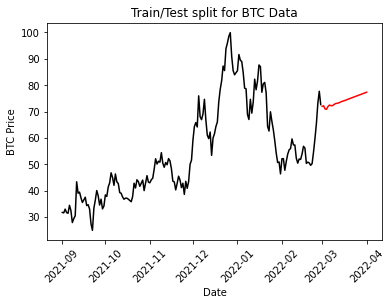

In [13]:
plt.plot(cur_price_data['Price'], color = "black", label = 'Train')
plt.plot(sarima_y_pred_df['improve_predictions'], color = "red", label = 'Test')

plt.ylabel('BTC Price')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("Train/Test split for BTC Data")
